In [3]:
import pandas as pd
import numpy as np
import sys
import os
import nltk
import gensim
import csv
import re
import pickle as pkl
import string

from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_curve, classification_report, accuracy_score
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from spacy.lang.nl import Dutch
import nl_bertje

from collections import Counter

import plotly

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
trainingfile = pd.read_csv('DatasetSA_classification.csv', sep=';')
trainingfile.dropna(subset=['SA Label'])
trainingfile = trainingfile[['FileName', 'FileCaption', 'Text', 'len_text', 'cleaned_text', 'SA Label' ]]
trainingfile = trainingfile.dropna(subset=['SA Label'])
trainingfile = trainingfile.drop_duplicates(subset= 'cleaned_text')
print(trainingfile.shape)
trainingfile.iloc[0]

(2119, 6)


FileName                                               NCV113.xml
FileCaption     NCV113 Meded pandrecht en inning verpande vord...
Text            Betreft: Mededeling pandrecht en inning verpan...
len_text                                                     1724
cleaned_text    Mededeling pandrecht en inning verpande vorder...
SA Label                                   informative/persuasive
Name: 0, dtype: object

# Approaching the task as multilabel classification problem

### SVM

In [3]:
labelencoder = LabelEncoder()
tfidf = TfidfVectorizer()
onehotencoder = OneHotEncoder()
count_vectorizer = CountVectorizer()

In [4]:
trainingfile = pd.read_csv('DatasetSA_classification.csv', sep=';')
trainingfile.dropna(subset=['SA Label'])
trainingfile = trainingfile[['FileName', 'FileCaption', 'Text', 'len_text', 'cleaned_text', 'SA Label' ]]
trainingfile = trainingfile.dropna(subset=['SA Label'])
trainingfile = trainingfile.drop_duplicates(subset= 'cleaned_text')

X = trainingfile["cleaned_text"]
y = trainingfile["SA Label"]
y_enc = labelencoder.fit_transform(y)
y_onehot = onehotencoder.fit_transform(y.values.reshape(-1,1)).toarray()

X_array = tfidf.fit_transform(X).toarray()

X_train, X_valtest, y_train, y_valtest = train_test_split(X_array, y_onehot, test_size=0.8, random_state=42, stratify=trainingfile['SA Label'])

X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size= 0.5, random_state=42, stratify=y_valtest)

print(y_onehot.shape)
print(Counter(y))
print()

test = onehotencoder.inverse_transform(y_onehot)

binary_rel_clf = BinaryRelevance(svm.SVC(kernel='rbf', C=5000, gamma='scale'))
binary_rel_clf.fit(X_train,y_train)


pred = binary_rel_clf.predict(X_val)
print("VALIDATION:")
print(accuracy_score(y_val, pred))
print(classification_report(y_val, pred))
#cm = confusion_matrix(pred, y_val, normalize=None, labels=labels)
#print(cm)
print()

pred = binary_rel_clf.predict(X_test)
print("TEST:")
print(accuracy_score(y_test, pred))
print(classification_report(y_test, pred))
#cm = confusion_matrix(labelencoder.inverse_transform(pred), labelencoder.inverse_transform(y_test), normalize=None, labels=labels)
#print(cm)
print()
print(type(pred))
pred


(2119, 5)
Counter({'informative/persuasive': 1125, 'directive/instructive': 487, 'declarative': 178, 'commissive': 171, 'miscellaneous': 158})

VALIDATION:
0.49174528301886794
              precision    recall  f1-score   support

           0       0.33      0.01      0.03        69
           1       0.58      0.10      0.17        71
           2       0.89      0.37      0.53       195
           3       0.72      0.74      0.73       450
           4       0.56      0.08      0.14        63

   micro avg       0.74      0.49      0.59       848
   macro avg       0.62      0.26      0.32       848
weighted avg       0.70      0.49      0.53       848
 samples avg       0.49      0.49      0.49       848




/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



TEST:
0.4716981132075472
              precision    recall  f1-score   support

           0       0.50      0.01      0.03        68
           1       0.50      0.06      0.10        72
           2       0.85      0.30      0.44       195
           3       0.68      0.74      0.71       450
           4       0.62      0.08      0.14        63

   micro avg       0.70      0.47      0.56       848
   macro avg       0.63      0.24      0.28       848
weighted avg       0.69      0.47      0.50       848
 samples avg       0.47      0.47      0.47       848


<class 'scipy.sparse.csc.csc_matrix'>


/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



<848x5 sparse matrix of type '<class 'numpy.float64'>'
	with 574 stored elements in Compressed Sparse Column format>

### DT


In [5]:
binary_rel_clf = BinaryRelevance(DecisionTreeClassifier(max_depth=15, random_state = 42))
binary_rel_clf.fit(X_train,y_train)

pred = binary_rel_clf.predict(X_val)
print("VALIDATION:")
print(accuracy_score(y_val, pred))
print(classification_report(y_val, pred))
print()

pred = binary_rel_clf.predict(X_test)
print("TEST:")
print(accuracy_score(y_test, pred))
print(classification_report(y_test, pred))
print()

VALIDATION:
0.40212264150943394
              precision    recall  f1-score   support

           0       0.38      0.28      0.32        69
           1       0.35      0.25      0.29        71
           2       0.72      0.55      0.62       195
           3       0.61      0.63      0.62       450
           4       0.39      0.25      0.31        63

   micro avg       0.59      0.52      0.56       848
   macro avg       0.49      0.39      0.43       848
weighted avg       0.58      0.52      0.55       848
 samples avg       0.46      0.52      0.48       848


TEST:
0.3856132075471698
              precision    recall  f1-score   support

           0       0.33      0.22      0.27        68
           1       0.38      0.24      0.29        72
           2       0.68      0.53      0.60       195
           3       0.61      0.59      0.60       450
           4       0.36      0.24      0.29        63

   micro avg       0.58      0.49      0.53       848
   macro avg       

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



# Undersampling the informative/persuasive category

In [6]:
trainingfile = pd.read_csv('DatasetSA_classification.csv', sep=';')
trainingfile.dropna(subset=['SA Label'])
trainingfile = trainingfile[['FileName', 'FileCaption', 'Text', 'len_text', 'cleaned_text', 'SA Label' ]]
trainingfile = trainingfile.dropna(subset=['SA Label'])
trainingfile = trainingfile.drop_duplicates(subset= 'cleaned_text')

X = trainingfile[["cleaned_text", "SA Label"]] ##SA Label will be deleted from the X later
y = trainingfile["SA Label"]
y_enc = labelencoder.fit_transform(y)

In [7]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=trainingfile['SA Label'])

X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size= 0.5, random_state=42, stratify=y_valtest)

In [8]:
X_train.shape

(1695, 2)

In [9]:
X_train = X_train.sort_values('SA Label', ignore_index=True)
print(Counter(X_train['SA Label']))
#X_train[X_train["SA Label"] == 'informative/persuasive']

Counter({'informative/persuasive': 900, 'directive/instructive': 390, 'declarative': 142, 'commissive': 137, 'miscellaneous': 126})


In [10]:
to_remove = X_train[X_train["SA Label"] == 'informative/persuasive'].iloc[400:]

X_train_undersampled = pd.concat([X_train, to_remove]).drop_duplicates(keep=False)

In [11]:
print(X_train.shape)
print(to_remove.shape)
print(X_train_undersampled.shape)

(1695, 2)
(500, 2)
(1195, 2)


In [12]:
X_train = X_train_undersampled['cleaned_text']
y_train = X_train_undersampled['SA Label']
X_val = X_val['cleaned_text']
X_test = X_test['cleaned_text']

y_train = labelencoder.fit_transform(y_train)

### SVM

In [13]:
def create_classifier(train_features, train_targets):
    model = svm.SVC(kernel='rbf', C=5000, gamma='scale')
    vec = DictVectorizer()
    features_vectorized = vec.fit_transform(train_features)
    model = model.fit(features_vectorized, train_targets)
    #model = model.fit(train_features, train_targets)
    return model, vec

def classify_data(model, vec, inputdata, outputfile):
    #/features = extract_features_and_labels(inputdata)[0]
    features_vec = vec.transform(inputdata)
    predictions = model.predict(features_vec)
     
    return predictions

In [14]:
nlp = Dutch()
nlp.add_pipe(nlp.create_pipe('sentencizer'))
nlp = nl_bertje.load()

def extract_features_labels(trainingfile):
    """trainingfile moet df zijn"""
    data = []
    targets = []
    index = -1
    new_dict = dict()
    features_list = []
    vector_list = []
    text_list = []
    shape_list = []
    
    trainingfile = trainingfile.values.tolist()
    
    for row in trainingfile:
        #print(row)
        text = row
        text = str(text).replace('\n\n', '')
        #print(text, len(text))
        if len(text) > 5:
            vector = nlp(text).vector
            #print(vector.shape)
            #shape_list.append(vector.shape)
        else:
            vector = np.zeros(768)
            #print(vector.shape)
            #shape_list.append(vector.shape)
        #label = row[-1]
        feature_dict = {
            'text' : text,
            #'vector' : vector,
            }
        
        #text_without_sw = 
        #print(text)
        #print(vector)
        #break
        data.append(feature_dict)
        #targets.append(label)
        #text_list.append(text)
        vector_list.append(vector)
            
    return data, vector_list  

In [15]:
X_train = extract_features_labels(X_train)[0]
X_val = extract_features_labels(X_val)[0]
X_test = extract_features_labels(X_test)[0]

In [16]:
model, vec = create_classifier(X_train, y_train)

In [17]:
pred = classify_data(model, vec, X_val, 'pred.csv')
print(Counter(y_train))
print(Counter(pred))
print(Counter(y_val))

Counter({3: 400, 2: 390, 1: 142, 0: 137, 4: 126})
Counter({3: 212})
Counter({3: 113, 2: 48, 1: 18, 0: 17, 4: 16})


VALIDATION:
                        precision    recall  f1-score   support

            commissive       0.00      0.00      0.00        17
           declarative       0.00      0.00      0.00        18
 directive/instructive       0.00      0.00      0.00        48
informative/persuasive       0.53      1.00      0.70       113
         miscellaneous       0.00      0.00      0.00        16

              accuracy                           0.53       212
             macro avg       0.11      0.20      0.14       212
          weighted avg       0.28      0.53      0.37       212

[[113  48  17  18  16]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]


/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



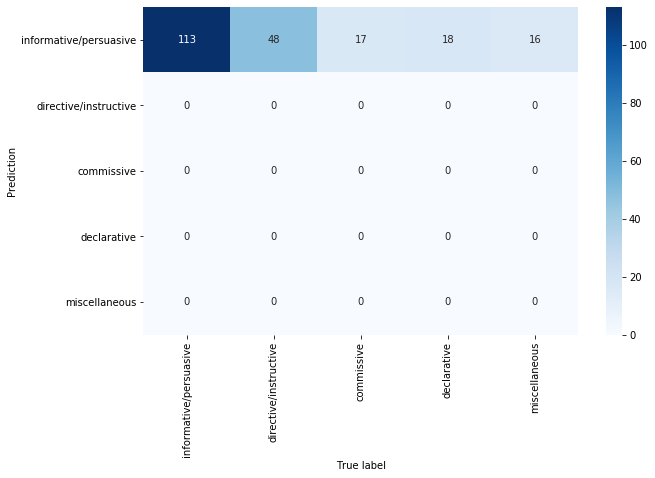

In [18]:
print("VALIDATION:")
print(classification_report(labelencoder.inverse_transform(y_val.tolist()),labelencoder.inverse_transform(pred.tolist())))

labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(labelencoder.inverse_transform(pred.tolist()), labelencoder.inverse_transform(y_val.tolist()), normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/Add_undersample_SVM_val.png')


In [19]:
pred = classify_data(model, vec, X_test, 'pred.csv')
print(Counter(y_train))
print(Counter(pred))
print(Counter(y_test))

Counter({3: 400, 2: 390, 1: 142, 0: 137, 4: 126})
Counter({3: 212})
Counter({3: 112, 2: 49, 1: 18, 0: 17, 4: 16})


TEST:
                        precision    recall  f1-score   support

            commissive       0.00      0.00      0.00        17
           declarative       0.00      0.00      0.00        18
 directive/instructive       0.00      0.00      0.00        49
informative/persuasive       0.53      1.00      0.69       112
         miscellaneous       0.00      0.00      0.00        16

              accuracy                           0.53       212
             macro avg       0.11      0.20      0.14       212
          weighted avg       0.28      0.53      0.37       212

[[112  49  17  18  16]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]


/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



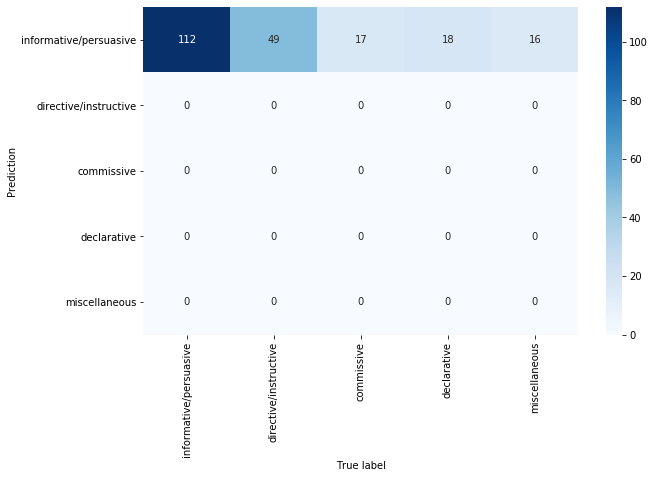

In [20]:
print("TEST:")
print(classification_report(labelencoder.inverse_transform(y_test.tolist()),labelencoder.inverse_transform(pred.tolist())))

cm = confusion_matrix(labelencoder.inverse_transform(pred.tolist()), labelencoder.inverse_transform(y_test.tolist()), normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/Add_undersample_SVM_test.png')


### DT

In [21]:
trainingfile = pd.read_csv('DatasetSA_classification.csv', sep=';')
trainingfile.dropna(subset=['SA Label'])
trainingfile = trainingfile[['FileName', 'FileCaption', 'Text', 'len_text', 'cleaned_text', 'SA Label' ]]
trainingfile = trainingfile.dropna(subset=['SA Label'])
trainingfile = trainingfile.drop_duplicates(subset= 'cleaned_text')

X = trainingfile[["cleaned_text", "SA Label"]] ##SA Label will be deleted from the X later
y = trainingfile["SA Label"]
y_enc = labelencoder.fit_transform(y)

X_train, X_valtest, y_train, y_valtest = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=trainingfile['SA Label'])
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size= 0.5, random_state=42, stratify=y_valtest)

In [22]:
X_train = X_train.sort_values('SA Label', ignore_index=True)
print(Counter(X_train['SA Label']))
X_train[X_train["SA Label"] == 'informative/persuasive']

to_remove = X_train[X_train["SA Label"] == 'informative/persuasive'][450:]
X_train_undersampled = pd.concat([X_train, to_remove]).drop_duplicates(keep=False)

X_train = X_train_undersampled['cleaned_text']
y_train = X_train_undersampled['SA Label']
X_val = X_val['cleaned_text']
X_test = X_test['cleaned_text']

print(Counter(y_train))

y_train = labelencoder.fit_transform(y_train)

Counter({'informative/persuasive': 900, 'directive/instructive': 390, 'declarative': 142, 'commissive': 137, 'miscellaneous': 126})
Counter({'informative/persuasive': 450, 'directive/instructive': 390, 'declarative': 142, 'commissive': 137, 'miscellaneous': 126})


In [23]:
X_train = extract_features_labels(X_train)[1]
X_val = extract_features_labels(X_val)[1]
X_test = extract_features_labels(X_test)[1]

In [24]:
clf_dt = DecisionTreeClassifier(max_depth=15, random_state = 42)
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, random_state=42)

In [25]:
pred_dt = clf_dt.predict(X_val)
print(clf_dt.get_depth())

print(clf_dt)

15
DecisionTreeClassifier(max_depth=15, random_state=42)


In [26]:
print("VALIDATION:")
print(classification_report(labelencoder.inverse_transform(y_val.tolist()),labelencoder.inverse_transform(pred_dt.tolist())))


VALIDATION:
                        precision    recall  f1-score   support

            commissive       0.22      0.41      0.29        17
           declarative       0.23      0.28      0.25        18
 directive/instructive       0.44      0.48      0.46        48
informative/persuasive       0.66      0.50      0.57       113
         miscellaneous       0.26      0.31      0.29        16

              accuracy                           0.46       212
             macro avg       0.36      0.40      0.37       212
          weighted avg       0.51      0.46      0.47       212



[[57 11  5  8  6]
 [19 23  4  2  4]
 [14  8  7  2  1]
 [14  2  1  5  0]
 [ 9  4  0  1  5]]


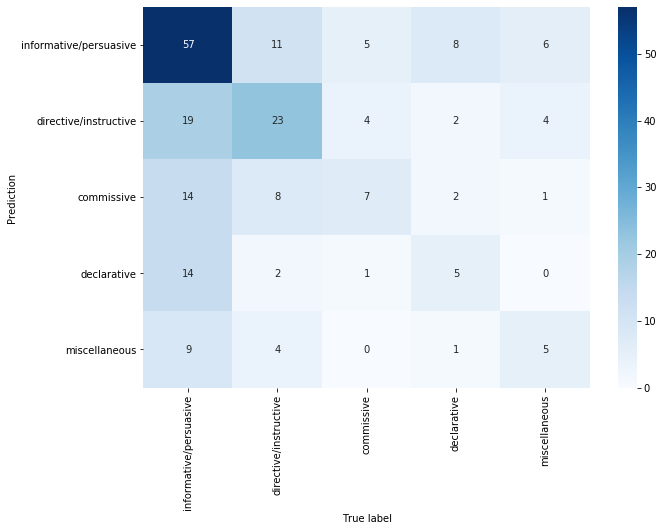

In [27]:

cm = confusion_matrix(labelencoder.inverse_transform(pred_dt.tolist()), labelencoder.inverse_transform(y_val.tolist()), normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")
labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
#plt.tight_layout(pad=2)
plot.figure.savefig('pics/Additional_DT_val_under.png')

TEST:
                        precision    recall  f1-score   support

            commissive       0.13      0.24      0.17        17
           declarative       0.14      0.17      0.15        18
 directive/instructive       0.41      0.49      0.44        49
informative/persuasive       0.69      0.47      0.56       112
         miscellaneous       0.30      0.44      0.36        16

              accuracy                           0.43       212
             macro avg       0.33      0.36      0.34       212
          weighted avg       0.50      0.43      0.45       212

[[53  7  4  6  7]
 [22 24  7  5  1]
 [13 13  4  1  0]
 [15  1  2  3  1]
 [ 9  4  0  3  7]]


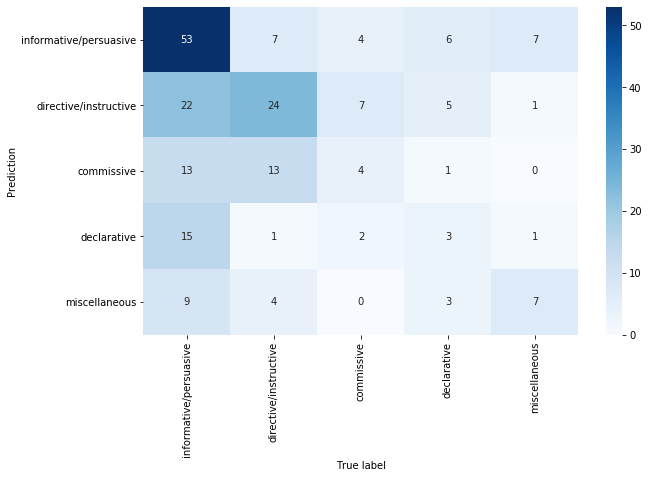

In [28]:
pred_dt = clf_dt.predict(X_test)

labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

print("TEST:")
print(classification_report(labelencoder.inverse_transform(y_test.tolist()),labelencoder.inverse_transform(pred_dt.tolist())))

cm = confusion_matrix(labelencoder.inverse_transform(pred_dt.tolist()), labelencoder.inverse_transform(y_test.tolist()), normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/Additional_DT_test_under.png')


## Oversampling declarative and commissive

In [29]:
trainingfile = pd.read_csv('DatasetSA_classification.csv', sep=';')
trainingfile.dropna(subset=['SA Label'])
trainingfile = trainingfile[['FileName', 'FileCaption', 'Text', 'len_text', 'cleaned_text', 'SA Label' ]]
trainingfile = trainingfile.dropna(subset=['SA Label'])
trainingfile = trainingfile.drop_duplicates(subset= 'cleaned_text')

X = trainingfile[["cleaned_text", "SA Label"]] ##SA Label will be deleted from the X later
y = trainingfile["SA Label"]
y_enc = labelencoder.fit_transform(y)

X_train, X_valtest, y_train, y_valtest = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=trainingfile['SA Label'])
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size= 0.5, random_state=42, stratify=y_valtest)



X_train = X_train.sort_values('SA Label', ignore_index=True)
print(Counter(X_train['SA Label']))


commissive = X_train[X_train["SA Label"] == 'commissive']
declarative = X_train[X_train["SA Label"] == 'declarative']

X_train_oversampled = pd.concat([X_train, commissive, declarative, commissive, declarative])
X_train_oversampled = X_train_oversampled.sample(frac=1).reset_index(drop=True)
print(Counter(X_train_oversampled['SA Label']))

X_train = X_train_oversampled['cleaned_text']
y_train = X_train_oversampled['SA Label']
X_val = X_val['cleaned_text']
X_test = X_test['cleaned_text']


y_train = labelencoder.fit_transform(y_train)

Counter({'informative/persuasive': 900, 'directive/instructive': 390, 'declarative': 142, 'commissive': 137, 'miscellaneous': 126})
Counter({'informative/persuasive': 900, 'declarative': 426, 'commissive': 411, 'directive/instructive': 390, 'miscellaneous': 126})


### SVM

In [30]:
X_train = extract_features_labels(X_train)[0]
X_val = extract_features_labels(X_val)[0]
X_test = extract_features_labels(X_test)[0]

model, vec = create_classifier(X_train, y_train)

In [31]:
pred = classify_data(model, vec, X_test, 'pred.csv')
print(Counter(y_train))
print(Counter(pred))
print(Counter(y_test))

Counter({3: 900, 1: 426, 0: 411, 2: 390, 4: 126})
Counter({3: 212})
Counter({3: 112, 2: 49, 1: 18, 0: 17, 4: 16})


VALIDATION:
                        precision    recall  f1-score   support

            commissive       0.00      0.00      0.00        17
           declarative       0.00      0.00      0.00        18
 directive/instructive       0.00      0.00      0.00        48
informative/persuasive       0.53      1.00      0.70       113
         miscellaneous       0.00      0.00      0.00        16

              accuracy                           0.53       212
             macro avg       0.11      0.20      0.14       212
          weighted avg       0.28      0.53      0.37       212

[[113  48  17  18  16]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]


/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



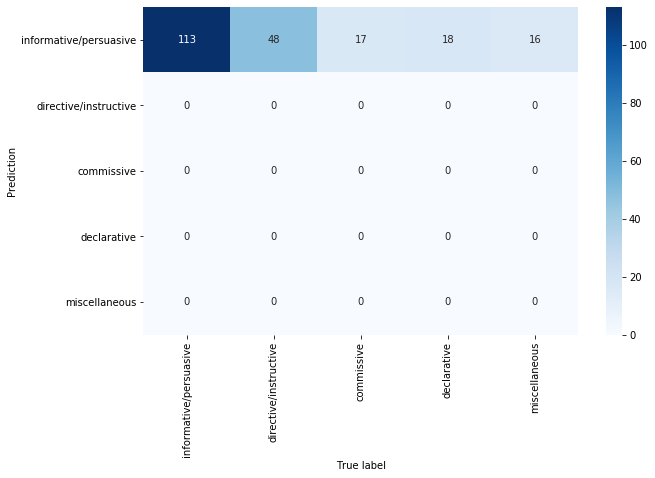

In [32]:
print("VALIDATION:")
print(classification_report(labelencoder.inverse_transform(y_val.tolist()),labelencoder.inverse_transform(pred.tolist())))

labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(labelencoder.inverse_transform(pred.tolist()), labelencoder.inverse_transform(y_val.tolist()), normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/Add_oversample_SVM_val.png')


TEST:
                        precision    recall  f1-score   support

            commissive       0.00      0.00      0.00        17
           declarative       0.00      0.00      0.00        18
 directive/instructive       0.00      0.00      0.00        49
informative/persuasive       0.53      1.00      0.69       112
         miscellaneous       0.00      0.00      0.00        16

              accuracy                           0.53       212
             macro avg       0.11      0.20      0.14       212
          weighted avg       0.28      0.53      0.37       212

[[112  49  17  18  16]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]


/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



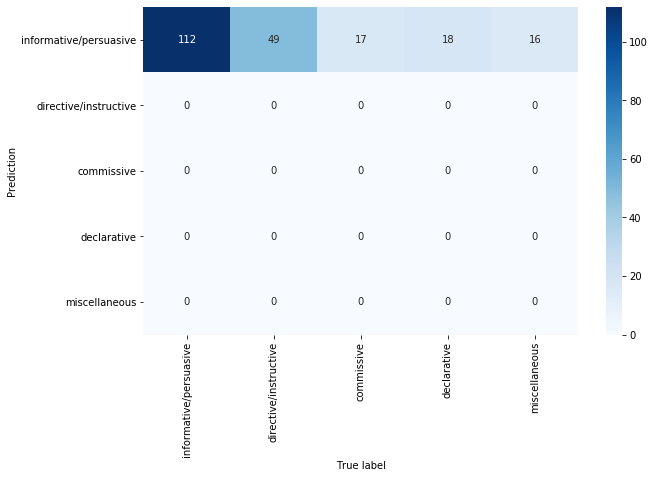

In [33]:
print("TEST:")
print(classification_report(labelencoder.inverse_transform(y_test.tolist()),labelencoder.inverse_transform(pred.tolist())))

cm = confusion_matrix(labelencoder.inverse_transform(pred.tolist()), labelencoder.inverse_transform(y_test.tolist()), normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/Add_oversample_SVM_test.png')

### DT

In [34]:
trainingfile = pd.read_csv('DatasetSA_classification.csv', sep=';')
trainingfile.dropna(subset=['SA Label'])
trainingfile = trainingfile[['FileName', 'FileCaption', 'Text', 'len_text', 'cleaned_text', 'SA Label' ]]
trainingfile = trainingfile.dropna(subset=['SA Label'])
trainingfile = trainingfile.drop_duplicates(subset= 'cleaned_text')

X = trainingfile[["cleaned_text", "SA Label"]] ##SA Label will be deleted from the X later
y = trainingfile["SA Label"]
y_enc = labelencoder.fit_transform(y)

X_train, X_valtest, y_train, y_valtest = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=trainingfile['SA Label'])
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size= 0.5, random_state=42, stratify=y_valtest)



X_train = X_train.sort_values('SA Label', ignore_index=True)
print(Counter(X_train['SA Label']))


commissive = X_train[X_train["SA Label"] == 'commissive']
declarative = X_train[X_train["SA Label"] == 'declarative']

X_train_oversampled = pd.concat([X_train, commissive, declarative])
print(Counter(X_train_oversampled['SA Label']))

X_train = X_train_oversampled['cleaned_text']
y_train = X_train_oversampled['SA Label']
X_val = X_val['cleaned_text']
X_test = X_test['cleaned_text']


y_train = labelencoder.fit_transform(y_train)



Counter({'informative/persuasive': 900, 'directive/instructive': 390, 'declarative': 142, 'commissive': 137, 'miscellaneous': 126})
Counter({'informative/persuasive': 900, 'directive/instructive': 390, 'declarative': 284, 'commissive': 274, 'miscellaneous': 126})


In [35]:
X_train.shape

(1974,)

In [36]:
X_train = extract_features_labels(X_train)[1]
X_val = extract_features_labels(X_val)[1]
X_test = extract_features_labels(X_test)[1]

In [37]:
clf_dt = DecisionTreeClassifier(max_depth=15, random_state = 42)
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, random_state=42)

In [38]:
pred_dt = clf_dt.predict(X_val)
print(clf_dt.get_depth())

print(clf_dt)

15
DecisionTreeClassifier(max_depth=15, random_state=42)


VALIDATION:
                        precision    recall  f1-score   support

            commissive       0.10      0.06      0.07        17
           declarative       0.14      0.11      0.12        18
 directive/instructive       0.48      0.52      0.50        48
informative/persuasive       0.67      0.69      0.68       113
         miscellaneous       0.35      0.44      0.39        16

              accuracy                           0.53       212
             macro avg       0.35      0.36      0.35       212
          weighted avg       0.51      0.53      0.52       212

[[78 14 10  8  6]
 [14 25  4  6  3]
 [ 6  3  1  0  0]
 [ 7  3  2  2  0]
 [ 8  3  0  2  7]]


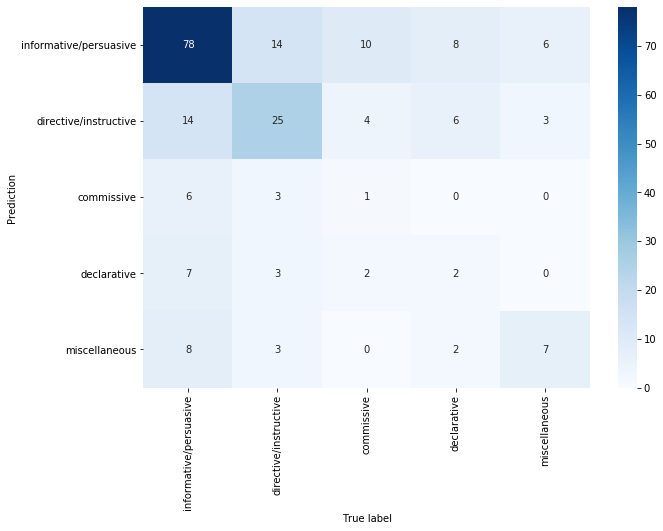

In [39]:
print("VALIDATION:")
print(classification_report(labelencoder.inverse_transform(y_val.tolist()),labelencoder.inverse_transform(pred_dt.tolist())))


cm = confusion_matrix(labelencoder.inverse_transform(pred_dt.tolist()), labelencoder.inverse_transform(y_val.tolist()), normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")
labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
#plt.tight_layout(pad=2)
plot.figure.savefig('pics/Additional_DT_val_over.png')

TEST:
                        precision    recall  f1-score   support

            commissive       0.16      0.18      0.17        17
           declarative       0.30      0.33      0.32        18
 directive/instructive       0.42      0.41      0.41        49
informative/persuasive       0.67      0.66      0.66       112
         miscellaneous       0.21      0.19      0.20        16

              accuracy                           0.50       212
             macro avg       0.35      0.35      0.35       212
          weighted avg       0.50      0.50      0.50       212

[[74 18  7  4  8]
 [15 20  5  6  2]
 [ 6  6  3  1  3]
 [10  2  2  6  0]
 [ 7  3  0  1  3]]


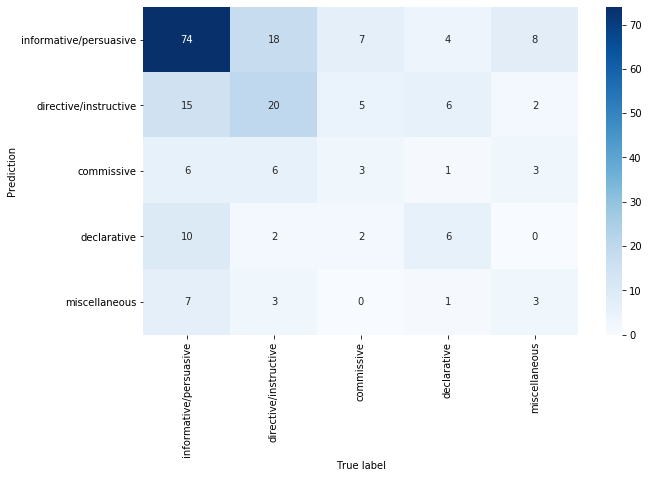

In [40]:
pred_dt = clf_dt.predict(X_test)

labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

print("TEST:")
print(classification_report(labelencoder.inverse_transform(y_test.tolist()),labelencoder.inverse_transform(pred_dt.tolist())))

cm = confusion_matrix(labelencoder.inverse_transform(pred_dt.tolist()), labelencoder.inverse_transform(y_test.tolist()), normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/Additional_DT_test_over.png')


# Under- and oversampling on CatBoost

In [18]:
data = pd.read_csv('DatasetSA_classification.csv', sep=';')
data = data[['FileName', 'FileCode', 'FileCaption', 'Text', 'len_text', 'cleaned_text', 'SA Label' ]]
data = data.dropna(subset=['SA Label'])
data = data.drop_duplicates(subset= 'cleaned_text')
data.shape

train_data, valtest_data = train_test_split(data[['FileCode', 'cleaned_text', 'SA Label']], stratify=data['SA Label'], test_size=0.2)
val_data, test_data = train_test_split(valtest_data[['FileCode', 'cleaned_text', 'SA Label']], stratify=valtest_data['SA Label'], test_size=0.5)

val_data.shape


(212, 3)

### undersampling

In [19]:
train_data = train_data.sort_values('SA Label', ignore_index=True)
print(Counter(train_data['SA Label']))
print(train_data.shape)


inf_pers_undersampled = train_data[train_data["SA Label"] == 'informative/persuasive'][450:]
inf_pers_undersampled
train_data = pd.concat([train_data, inf_pers_undersampled]).drop_duplicates(keep=False)
train_data.shape

#X_train = X_train_oversampled['cleaned_text']
#y_train = X_train_oversampled['SA Label']
#X_val = X_val['cleaned_text']
#X_test = X_test['cleaned_text']

Counter({'informative/persuasive': 900, 'directive/instructive': 390, 'declarative': 142, 'commissive': 137, 'miscellaneous': 126})
(1695, 3)


(1245, 3)

In [20]:
print(Counter(train_data['SA Label']))

Counter({'informative/persuasive': 450, 'directive/instructive': 390, 'declarative': 142, 'commissive': 137, 'miscellaneous': 126})


In [21]:
train_texts = train_data['cleaned_text'].tolist()
train_labels = train_data['SA Label'].tolist()
valid_texts = val_data['cleaned_text'].tolist()
valid_labels = val_data['SA Label'].tolist()
test_texts = test_data['cleaned_text'].tolist()
test_labels = test_data['SA Label'].tolist()

In [22]:
X_train = pd.DataFrame(train_texts, columns=['text'])
y_train = train_data['SA Label']

X_valid = pd.DataFrame(valid_texts, columns=['text'])
y_valid = val_data['SA Label']


X_test  = pd.DataFrame(test_texts, columns=['text'])
y_test  = test_data['SA Label']

train_data_pool = Pool(X_train, y_train, text_features=['text'])
valid_data_pool = Pool(X_valid, y_valid, text_features=['text'])
test_data_pool = Pool(X_test, X_test, text_features=['text'])

In [23]:
quick_model = CatBoostClassifier(iterations=100
                          , depth=1
                          , learning_rate=None
                          , objective= 'MultiClass'
                          , loss_function='MultiClass'
                          , eval_metric= 'MultiClass'
                          , verbose=False
                          , auto_class_weights='Balanced')



quick_model.fit(train_data_pool)


results_val = quick_model.predict(X_valid)
print("VALIDATION:")
print(classification_report(y_valid.tolist(),results_val.tolist()))
print()


VALIDATION:
                        precision    recall  f1-score   support

            commissive       0.00      0.00      0.00        17
           declarative       1.00      0.22      0.36        18
 directive/instructive       0.85      0.35      0.50        48
informative/persuasive       0.53      0.42      0.47       113
         miscellaneous       0.16      0.94      0.27        16

              accuracy                           0.40       212
             macro avg       0.51      0.39      0.32       212
          weighted avg       0.57      0.40      0.42       212




[[48  2  2  0 61]
 [21 17  0  0 10]
 [12  1  0  0  4]
 [ 8  0  0  4  6]
 [ 1  0  0  0 15]]


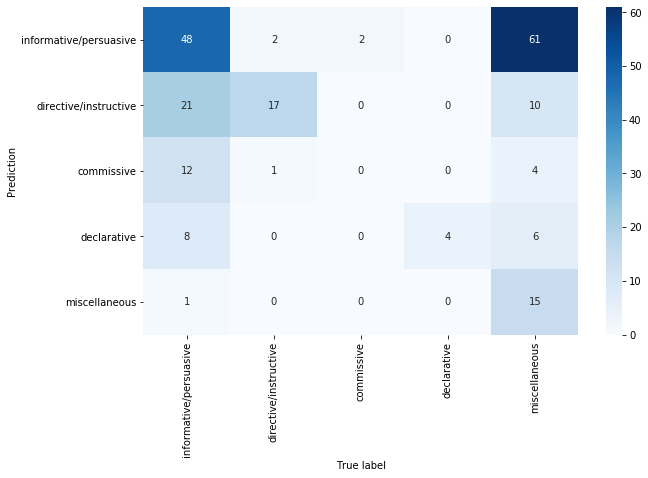

In [24]:
labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(y_valid, results_val, normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/Additional_Catboost_val_under.png')

In [25]:
results_test = quick_model.predict(X_test)
print("TEST:")
print(classification_report(y_test.tolist(),results_test.tolist()))
print()

TEST:
                        precision    recall  f1-score   support

            commissive       0.80      0.24      0.36        17
           declarative       0.20      0.06      0.09        18
 directive/instructive       0.88      0.31      0.45        49
informative/persuasive       0.55      0.50      0.53       112
         miscellaneous       0.17      0.88      0.28        16

              accuracy                           0.42       212
             macro avg       0.52      0.39      0.34       212
          weighted avg       0.59      0.42      0.44       212




[[56  2  0  4 50]
 [24 15  0  0 10]
 [11  0  4  0  2]
 [ 8  0  1  1  8]
 [ 2  0  0  0 14]]


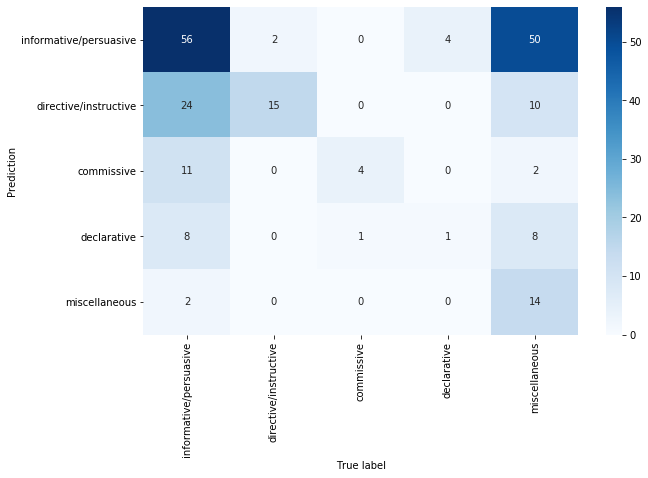

In [26]:
labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(y_test, results_test, normalize=None, labels=labels)

print(cm)

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/Additional_Catboost_test_under.png')

### Oversampling

In [4]:
data = pd.read_csv('DatasetSA_classification.csv', sep=';')
data = data[['FileName', 'FileCode', 'FileCaption', 'Text', 'len_text', 'cleaned_text', 'SA Label' ]]
data = data.dropna(subset=['SA Label'])
data = data.drop_duplicates(subset= 'cleaned_text')
data.shape

train_data, valtest_data = train_test_split(data[['FileCode', 'cleaned_text', 'SA Label']], stratify=data['SA Label'], test_size=0.2)
val_data, test_data = train_test_split(valtest_data[['FileCode', 'cleaned_text', 'SA Label']], stratify=valtest_data['SA Label'], test_size=0.5)

val_data.shape

(212, 3)

In [5]:
train_texts = train_data['cleaned_text'].tolist()
train_labels = train_data['SA Label'].tolist()
valid_texts = val_data['cleaned_text'].tolist()
valid_labels = val_data['SA Label'].tolist()
test_texts = test_data['cleaned_text'].tolist()
test_labels = test_data['SA Label'].tolist()



In [6]:
X_train = pd.DataFrame(train_texts, columns=['text'])
y_train = train_data['SA Label']

X_valid = pd.DataFrame(valid_texts, columns=['text'])
y_valid = val_data['SA Label']


X_test  = pd.DataFrame(test_texts, columns=['text'])
y_test  = test_data['SA Label']

train_data_pool = Pool(X_train, y_train, text_features=['text'])
valid_data_pool = Pool(X_valid, y_valid, text_features=['text'])
test_data_pool = Pool(X_test, X_test, text_features=['text'])

In [7]:
quick_model = CatBoostClassifier(iterations=100
                          , depth=1
                          , learning_rate=None
                          , objective= 'MultiClass'
                          , loss_function='MultiClass'
                          , eval_metric= 'MultiClass'
                          , verbose=False
                          , auto_class_weights='Balanced')



quick_model.fit(train_data_pool)


results_val = quick_model.predict(X_valid)
print("VALIDATION:")
print(classification_report(y_valid.tolist(),results_val.tolist()))
print()

VALIDATION:
                        precision    recall  f1-score   support

            commissive       0.40      0.59      0.48        17
           declarative       0.54      0.83      0.65        18
 directive/instructive       0.76      0.57      0.65        49
informative/persuasive       0.80      0.58      0.67       112
         miscellaneous       0.34      0.88      0.49        16

              accuracy                           0.62       212
             macro avg       0.57      0.69      0.59       212
          weighted avg       0.70      0.62      0.64       212




[[65  8  8 10 21]
 [11 28  6  0  4]
 [ 3  1 10  2  1]
 [ 1  0  1 15  1]
 [ 1  0  0  1 14]]


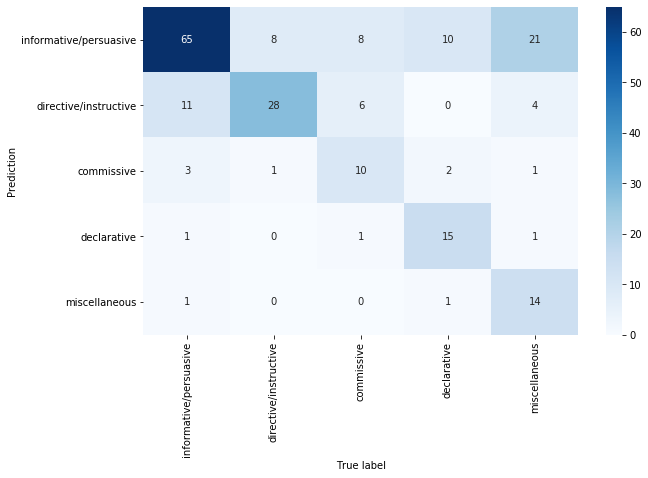

In [8]:
labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(y_valid, results_val, normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/Additional_Catboost_val_over.png')

In [9]:
results_test = quick_model.predict(X_test)
print("TEST:")
print(classification_report(y_test.tolist(),results_test.tolist()))
print()

TEST:
                        precision    recall  f1-score   support

            commissive       0.55      0.65      0.59        17
           declarative       0.54      0.72      0.62        18
 directive/instructive       0.78      0.73      0.75        48
informative/persuasive       0.84      0.65      0.73       113
         miscellaneous       0.36      0.81      0.50        16

              accuracy                           0.68       212
             macro avg       0.61      0.71      0.64       212
          weighted avg       0.74      0.68      0.70       212




[[73  6  3  3  2]
 [ 7 35  2  0  1]
 [ 5  4 11  0  0]
 [ 9  1  1 13  0]
 [19  2  0  2 13]]


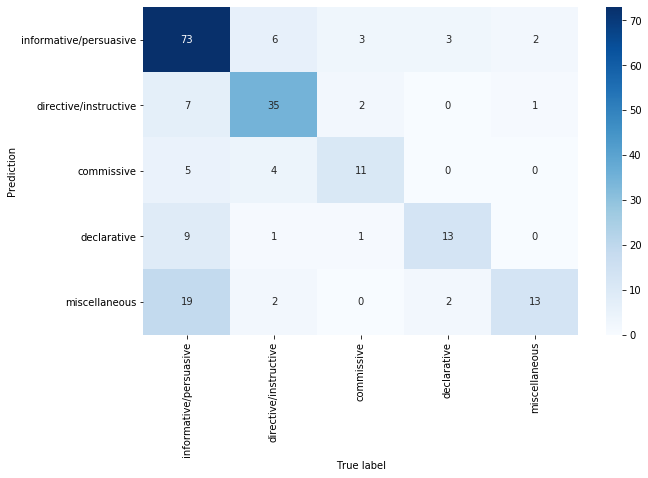

In [10]:
labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(results_test, y_test, normalize=None, labels=labels)

print(cm)

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/Additional_Catboost_test_over.png')

### error analysis

In [12]:
error_analysis = pd.DataFrame()
error_analysis['cleaned_text'] = X_test['text']
error_analysis['gold_label'] = y_test.to_list()
error_analysis['prediction'] = results_test

#ik = error_analysis['cleaned_text'].str.contains('ik|Ik')
#u = error_analysis['cleaned_text'].str.contains('u |U ')
#print(Counter(ik))
#print(Counter(u))
#error_analysis_comm = error_analysis
#error_analysis_comm['ik'] = ik
#error_analysis_comm['u'] = u

#comm = error_analysis_comm[error_analysis_comm['gold_label'] == 'commissive']
#print(comm.shape)
#print(Counter(comm['ik']))
#print(Counter(comm['u']))

#error_analysis.columns

In [31]:
counter = 0
error_counter = 0
values_list = []
values_counter = 0
zero_dict_counter = 0
ik_counter = 0
u_counter = 0
client_counter = 0
for row in error_analysis.values:
    counter += 1
    #print(row)
    #break
    if row[1] != row[2]:
        error_counter += 1
        if row[1] == 'informative/persuasive' and row[2] == "directive/instructive":
            print(row)
            zero_dict_counter += 1
            #print("Sentence: ", row[0])
            #print("gold label: ", row[-2], '-- predicted label: ', row[-1])
            print()
        if error_counter == 20:
            break
    #if row[-1] == row[-2]:
        #if row[-2] == 'directive/instructive':
            #if "artikel" in row[0].lower():
                #u_counter += 1
            #print(row)
            #print()
    #if 'u ' in row[0].lower():
     #   u_counter += 1
        #print(row)
    #if 'ik ' in row[0].lower():
    #    ik_counter += 1
        #print(row)
   # if ' uw cli' in row[0].lower():
    #    client_counter += 1
    #if "artikel" in row[0].lower():
       # ik_counter += 1
       # print(row)
        
        
        
print("FINAL COUNTS")        
print("counter: ", counter)
print("errors: ", error_counter)
print("ik, u, cl:", ik_counter, u_counter, client_counter)


['Meer informatie hierover vindt u op belastingdienst.nl .'
 'informative/persuasive' 'directive/instructive']

['Ik heb dat gedaan, omdat het voor mij niet mogelijk is uit de door u aangeleverde gegevens te concluderen wat u precies beoogt.'
 'informative/persuasive' 'directive/instructive']

FINAL COUNTS
counter:  57
errors:  20
ik, u, cl: 0 0 0


In [26]:
train_df = X_train[['text']]
train_df['label'] = y_train
train_df['artikel'] = train_df['text'].str.contains('artikel')
train_df[train_df['label'] == 'declarative'].shape
decl_df = train_df[train_df['label'] == 'declarative']

In [30]:
print(Counter(decl_df['text'].str.contains(' artikel ')))
print(Counter(train_df['text'].str.contains(' artikel ')))

Counter({False: 124, True: 4})
Counter({False: 1621, True: 74})
